<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Xander Gallegos, Carlos Emiliano Rodríguez.

**Fecha:** 15 de febrero del 2024.

**Expediente** : 737989, XXXXXX.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: <a href=https://github.com/xagallegos/ProyectoConjunto_XGallegos_CERodriguez>ProyectoConjunto_XGallegos_CERodriguez</a>

# Tarea 3: Clase 7

## Enunciado de tarea 

> Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado.

> Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase. Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos: <https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true>

### Ejercicio 1: Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado.

Código de solución estudiante 1

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose, MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO
from sklearn.preprocessing import power_transform, MinMaxScaler, StandardScaler
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

In [27]:
# Código de solución estudiante 1
class LinearForecast:
    def __init__(self, file_path, file_type='csv', kwargs = dict(), train_split=0.8):
        if file_type == 'csv':
            self.data = pd.read_csv(file_path, **kwargs)
        elif file_type == 'xlsx':
            self.data = pd.read_excel(file_path, **kwargs)
        else:
            raise ValueError(f'Unexpected value "{file_type}"')

        s = int(self.data.shape[0] * train_split)
        self.train = self.data[:s]
        self.test = self.data[s:]

    def seasonal_decomposition(self, periods_seasonality, plot=False):
        decomposition_model = MSTL(self.data, periods=periods_seasonality)
        result = decomposition_model.fit()
        
        if plot == True:
            n = 3 + len(periods_seasonality)
            fig, axes = plt.subplots(n, 1, figsize=(8,8))
            
            result.observed.plot(ax=axes[0])
            axes[0].set_ylabel('Observed')

            result.trend.plot(ax=axes[1])
            axes[1].set_ylabel('Trend')

            for i, period in enumerate(periods_seasonality):
                result.seasonal[f'seasonal_{period}'].plot(ax=axes[2+i])
                axes[2+i].set_ylabel(f'seasonal_{period}')

            result.resid.plot(ax=axes[-1])
            axes[-1].set_ylabel('Residual')
        
        return result
        
    def adf_test(self, diff=0):
        if diff == 0:
            data = self.data
        elif diff == 1:
            data = self.data.diff().dropna()
        elif diff == 2:
            data = self.data.diff().diff().dropna()
        else:
            raise ValueError(f'Unexpected value "{diff}"')
        
        dftest = adfuller(data, autolag = "AIC")
        dfoutput = pd.Series(dftest[0:4],
                             index = ["Test Statistic",
                                      "p-value",
                                      "#Lags Used",
                                      "Number of Observations Used"])
        
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
            
        print(f"Results of Dickey-Fuller Test: (diff: {diff})")
        print(dfoutput)
        
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")
            
    def plot_acf_pac(self, split, diff=0, kwargs=dict()):
        data = self.data[:split]
        
        if diff == 0:
            data = data
        elif diff == 1:
            data = data.diff().dropna()
        elif diff == 2:
            data = data.diff().diff().dropna()
        else:
            raise ValueError(f'Unexpected value "{diff}"')
        
        f = plt.figure(figsize=(10,3))

        ax1 = f.add_subplot(121)
        plot_acf(data, zero=False, ax=ax1, **kwargs)
    
        ax2 = f.add_subplot(122)
        plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)
    
        plt.show()

    def transform_timeseries(self, how='sqrt'):
        if how == 'sqrt':
            return np.sqrt(self.data)
        elif how == 'log':
            return np.log(self.data)
        elif how in ['box-cox', 'yeo-johnson']:
            return power_transform(self.data.to_numpy().reshape(-1,1), method=how)
        elif how == 'min-max-scaler':
            scaler = MinMaxScaler()
            return mm_scaler.fit_transform(self.data)
        elif how == 'std-scaler':
            scaler = StandardScaler()
            return scaler.fit_transform(self.data.values.reshape(-1, 1))
        else:
            raise ValueError(f'Unexpected value "{how}"')

    def sarimax_model(self, params):
        non_seasonal, seasonal, trend = params
        model = SARIMAX(
            endog = non_seasonal,
            trend = trend,
            order = non_seasonal,
            seasonal_order = seasonal
        )
        return model.fit()

    def predict(self, model, plot=False):
        y_h = model.predict(start=self.test.index[0], end=self.test.index[-1])

        if plot is True:
            fig, ax = plt.subplots(figsize = (10, 5))
            self.test.plot(ax = ax)
            ax.plot(y_h)
            ax.legend(labels = ['data', 'forecast'])
            
        return y_h
    
    def eval_model(self, y_h):
        mape = np.mean(np.abs((np.array(self.test) - y_h) / np.array(self.test)))
        mad = np.mean(np.abs(np.array(self.test) - y_h))
        return mape, mad
        

Código de solución estudiante 2

In [2]:
# Código de solución estudiante 2

### Ejercicio 2: Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase. Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos: <https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true>

Código de solución de estudiante 1

In [28]:
# Código de solución de estudiante 1
file = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'
forecast = LinearForecast(file, 'xlsx')

In [29]:
backup = deepcopy(forecast)

In [30]:
for df in [forecast.data, forecast.train, forecast.test]:
    # Sumar fecha y hora
    df.date = [d + pd.Timedelta(h, unit='hour') for d, h in df[['date', 'hour']].values]
    df.set_index('date', inplace=True) # asignarla como índice
    
    # Conservar únicamente la fecha y la columna a predecir -> energía
    df.drop(columns = [c for c in df.columns if c != 'Energy (kWh)'], inplace=True)

print(forecast.data.shape)
forecast.data.head()

(97000, 1)


,Energy (kWh)
date,
1990-01-01 06:00:00,498.632
1990-01-01 07:00:00,720.409
1990-01-01 08:00:00,946.154
1990-01-01 09:00:00,987.273
1990-01-01 10:00:00,1000.230


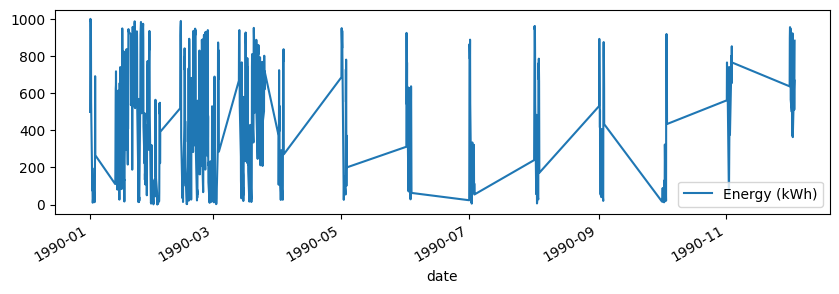

In [31]:
# Graficar la serie de tiempo
forecast.data[:1000].plot(figsize=(10,3))
plt.show()

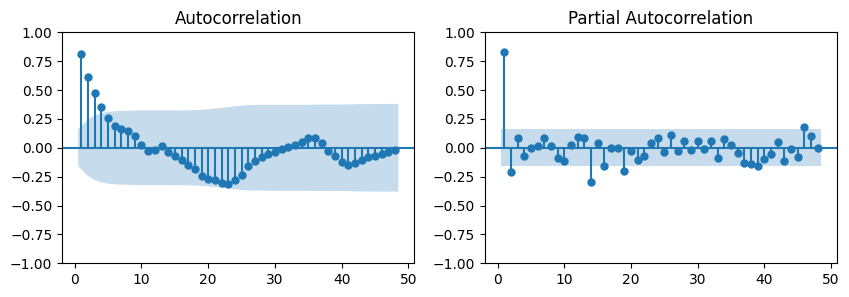

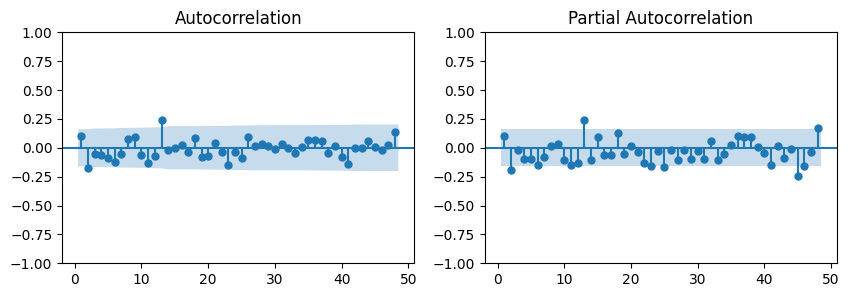

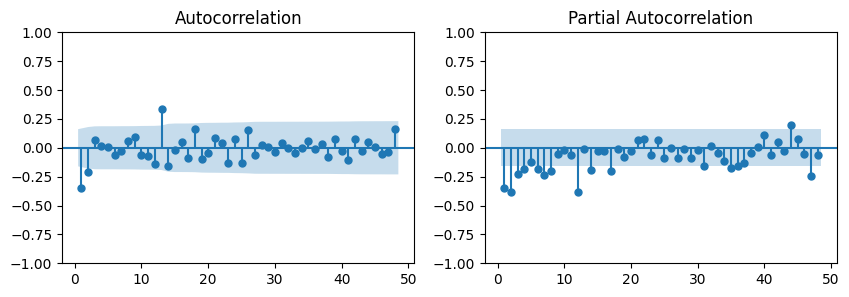

In [37]:
# Graficar ACF y PAC
forecast.plot_acf_pac(split=150, kwargs={'lags': 48})
forecast.plot_acf_pac(split=150, diff=1, kwargs={'lags': 48})
forecast.plot_acf_pac(split=150, diff=2, kwargs={'lags': 48})

In [38]:
forecast.adf_test()
forecast.adf_test(diff=1)
forecast.adf_test(diff=2)

Results of Dickey-Fuller Test: (diff: 0)
Test Statistic                   -28.225750
p-value                            0.000000
#Lags Used                        67.000000
Number of Observations Used    96932.000000
Critical Value (1%)               -3.430417
Critical Value (5%)               -2.861570
Critical Value (10%)              -2.566786
dtype: float64
Stationary
Results of Dickey-Fuller Test: (diff: 1)
Test Statistic                   -60.133807
p-value                            0.000000
#Lags Used                        67.000000
Number of Observations Used    96931.000000
Critical Value (1%)               -3.430417
Critical Value (5%)               -2.861570
Critical Value (10%)              -2.566786
dtype: float64
Stationary
Results of Dickey-Fuller Test: (diff: 2)
Test Statistic                   -75.680761
p-value                            0.000000
#Lags Used                        67.000000
Number of Observations Used    96930.000000
Critical Value (1%)              

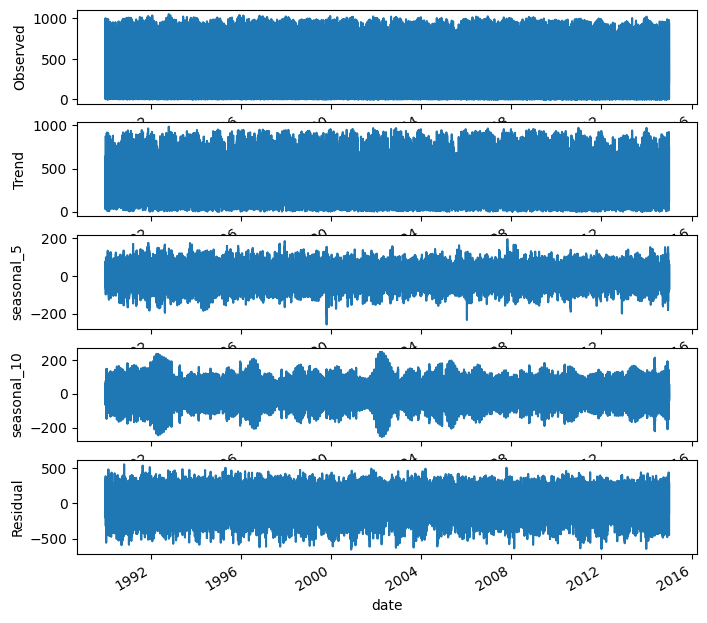

In [39]:
decomposed_series = forecast.seasonal_decomposition((5,10), plot=True)

In [89]:
model = forecast.sarimax_model(((1,0,3), (0,0,0,12), 'n'))
y_h = forecast.predict(model)
y_h.shape

(20,)

In [90]:
forecast.eval_model(y_h)

(1.0, 186.2)

Código de solución de estudiante 2

In [4]:
# Código de solución de estudiante 2